In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#function to convert dataframe to into 2d array
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame;

In [ ]:
#view of a sample of data
df=pd.read_csv("/content/drive/My Drive/dataset/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [ ]:
#for concatenating all the files and
#Preprocessing the data
from sklearn import preprocessing
import glob
path = r'/content/drive/My Drive/dataset/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

dataset_conc=[]
for filename in all_files:
  df=pd.read_csv(filename,index_col=None,header=0)
  df=df.replace(0,np.nan)
  df=df.dropna(axis=0, how='any',subset=['value'])
  df.value = preprocessing.normalize([df.value]).T
  dataset_conc.append(convert_2d(df)) 
frame=pd.concat(dataset_conc,axis=0,ignore_index=True)


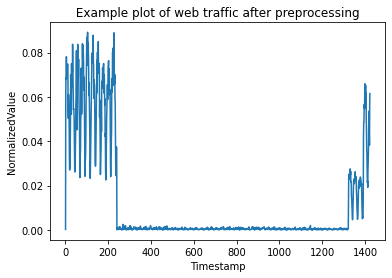

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Flatten,MaxPooling1D,Conv1D,LSTM
from keras import optimizers

Using TensorFlow backend.


In [ ]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=10, strides=1, padding='same', activation='relu',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=10, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='relu',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 60, 64)            704       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 30, 64)            41024     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1, 960)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             262400    
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)               

In [ ]:
frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.026068,0.026184,0.026419,0.025958,0.025380,0.024741,0.025584,0.026244,0.027114,0.026844,0.026618,0.025602,0.026470,0.025580,0.029036,0.025032,0.025083,0.025430,0.024543,0.024186,0.024387,0.025024,0.024290,0.024399,0.023791,0.024759,0.024350,0.024768,0.024500,0.023993,0.023363,0.023821,0.024699,0.025747,0.025132,0.024668,0.025307,0.027054,0.027379,0.025974,0.026547,0.027954,0.025826,0.026003,0.025692,0.025832,0.025210,0.025620,0.026187,0.025933,0.026248,0.026422,0.025538,0.027617,0.025258,0.026398,0.026027,0.027960,0.026736,0.025262,0.0
1,0.026184,0.026419,0.025958,0.025380,0.024741,0.025584,0.026244,0.027114,0.026844,0.026618,0.025602,0.026470,0.025580,0.029036,0.025032,0.025083,0.025430,0.024543,0.024186,0.024387,0.025024,0.024290,0.024399,0.023791,0.024759,0.024350,0.024768,0.024500,0.023993,0.023363,0.023821,0.024699,0.025747,0.025132,0.024668,0.025307,0.027054,0.027379,0.025974,0.026547,0.027954,0.025826,0.026003,0.025692,0.025832,0.025210,0.025620,0.026187,0.025933,0.026248,0.026422,0.025538,0.027617,0.025258,0.026398,0.026027,0.027960,0.026736,0.025262,0.025795,0.0
2,0.026419,0.025958,0.025380,0.024741,0.025584,0.026244,0.027114,0.026844,0.026618,0.025602,0.026470,0.025580,0.029036,0.025032,0.025083,0.025430,0.024543,0.024186,0.024387,0.025024,0.024290,0.024399,0.023791,0.024759,0.024350,0.024768,0.024500,0.023993,0.023363,0.023821,0.024699,0.025747,0.025132,0.024668,0.025307,0.027054,0.027379,0.025974,0.026547,0.027954,0.025826,0.026003,0.025692,0.025832,0.025210,0.025620,0.026187,0.025933,0.026248,0.026422,0.025538,0.027617,0.025258,0.026398,0.026027,0.027960,0.026736,0.025262,0.025795,0.025594,0.0
3,0.025958,0.025380,0.024741,0.025584,0.026244,0.027114,0.026844,0.026618,0.025602,0.026470,0.025580,0.029036,0.025032,0.025083,0.025430,0.024543,0.024186,0.024387,0.025024,0.024290,0.024399,0.023791,0.024759,0.024350,0.024768,0.024500,0.023993,0.023363,0.023821,0.024699,0.025747,0.025132,0.024668,0.025307,0.027054,0.027379,0.025974,0.026547,0.027954,0.025826,0.026003,0.025692,0.025832,0.025210,0.025620,0.026187,0.025933,0.026248,0.026422,0.025538,0.027617,0.025258,0.026398,0.026027,0.027960,0.026736,0.025262,0.025795,0.025594,0.026973,0.0
4,0.025380,0.024741,0.025584,0.026244,0.027114,0.026844,0.026618,0.025602,0.026470,0.025580,0.029036,0.025032,0.025083,0.025430,0.024543,0.024186,0.024387,0.025024,0.024290,0.024399,0.023791,0.024759,0.024350,0.024768,0.024500,0.023993,0.023363,0.023821,0.024699,0.025747,0.025132,0.024668,0.025307,0.027054,0.027379,0.025974,0.026547,0.027954,0.025826,0.026003,0.025692,0.025832,0.025210,0.025620,0.026187,0.025933,0.026248,0.026422,0.025538,0.027617,0.025258,0.026398,0.026027,0.027960,0.026736,0.025262,0.025795,0.025594,0.026973,0.026307,0.0


In [ ]:
#train test split
y=frame.iloc[:, 60]
X=frame.iloc[:, 0:60]
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [ ]:
#reshaping the data 
X_train=X_train.to_numpy()
nrows, ncols = X_train.shape
X_train = X_train.reshape(nrows, ncols, 1)

X_test=X_test.to_numpy()
nrows, ncols = X_test.shape
X_test = X_test.reshape(nrows, ncols, 1)

y_test = y_test.to_numpy()


In [ ]:
#converting y_train to categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train)

In [ ]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
62107/62107 [==============================] - 2s 26us/step - loss: 0.3503 - accuracy: 0.9009
Epoch 2/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2696 - accuracy: 0.9186
Epoch 3/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2609 - accuracy: 0.9222
Epoch 4/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2552 - accuracy: 0.9233
Epoch 5/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2472 - accuracy: 0.9248
Epoch 6/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2434 - accuracy: 0.9254
Epoch 7/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2369 - accuracy: 0.9263
Epoch 8/500
62107/62107 [==============================] - 1s 17us/step - loss: 0.2328 - accuracy: 0.9276
Epoch 9/500
62107/62107 [==============================] - 1s 18us/step - loss: 0.2298 - accuracy: 0.9289
Epoch 10/500
62107/62107 [====================

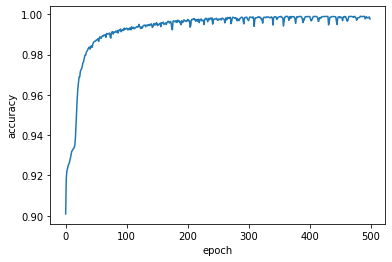

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [ ]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


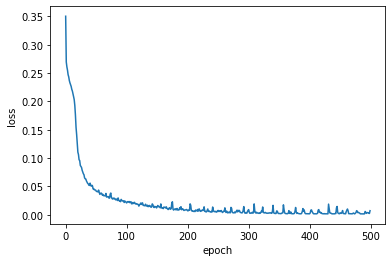

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 #predicting on test data
  
y_pred=model.predict_classes(X_test)

In [ ]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred)
Accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
F1_Score = f1_score(y_test, y_pred, average='binary')

In [ ]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[23509   784]
 [  627  1698]]
Accuracy  0.9469907581335938
Precision  0.6841257050765511
recall  0.7303225806451613
f1_score  0.7064697316413563
